In [96]:
batch_size = 64
crop_size = 180

In [97]:
import os, sys
from pathlib import Path

project_path = Path(os.getcwd())
sys.path.append(str(project_path) +'/')

train_csv_path = Path('/data/Code/macaw/data/ukbb/train_hc.csv')
train_img_path = Path('/data/Code/macaw/data/ukbb/axial/train_hc')

test_csv_path = Path('/data/Code/macaw/data/ukbb/test_hc.csv')
test_img_path = Path('/data/Code/macaw/data/ukbb/axial/test_hc')

In [98]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np

def show(data,n=4):
    fig, axs = plt.subplots(ncols=n, squeeze=False, figsize=(10,10))
    for i in range(n):
        img = F.to_pil_image(data[3][i].detach())
        axs[0, i].imshow(np.asarray(img), cmap='cividis')        
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], xlabel=make_label(data,i))
        
def make_label(d,i):
    s = ['Female', 'Male']
    return f"Sex: {s[int(d[0][i])]},  Age: {np.round(d[1][i])},\n BMI: {np.round(d[2][i],2)}"

In [99]:
import torch 
from utils.datasets import UKBBT1Dataset
from torchvision import transforms
from torchvision.transforms import ToTensor, CenterCrop, Resize, InterpolationMode
from utils.customTransforms import ToFloatUKBB
from torch.utils.data import DataLoader, random_split
import math

train_dataset = UKBBT1Dataset(train_csv_path, train_img_path, transforms.Compose([ToFloatUKBB(),ToTensor(), CenterCrop(crop_size), Resize(64,InterpolationMode.BILINEAR)]))

m =len(train_dataset)
train_data, val_data = random_split(train_dataset, [math.floor(m-m*0.2), math.ceil(m*0.2)], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [100]:
test_dataset = UKBBT1Dataset(test_csv_path, test_img_path, transforms.Compose([ToFloatUKBB(),ToTensor(), CenterCrop(crop_size), Resize(64,InterpolationMode.BILINEAR)]))
test_loader = DataLoader(test_dataset, batch_size=batch_size)

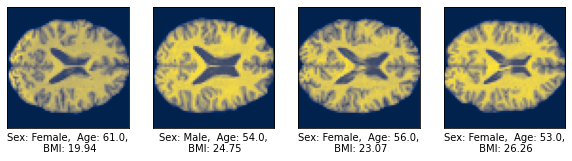

In [101]:
show(next(iter(val_loader)))

In [102]:
import torch
from  torch.utils.data import DataLoader,random_split
import math
import numpy as np
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle
from automacaw_ukbb import automacaw_ukbb
from utils.helpers import EarlyStopper as ES

In [153]:
encoded_dim = 128
automacaw_model = automacaw_ukbb(encoded_dim)
losses = {'mse_train_loss':[],'mse_val_loss':[],'nll_train_loss':[],'nll_val_loss':[]}

Selected device: cuda


In [104]:
automacaw_model.encoded_dim

256

## Train AE

In [105]:
es = ES(patience=3, min_delta=0.00005)

for epoch in (pbar := tqdm(range(500))):    
    mse_train_loss = automacaw_model.train_ae(train_loader, lr=0.001)
    mse_val_loss  = automacaw_model.test_MSE(val_loader)
    
    losses['mse_train_loss'].append(mse_train_loss)    
    losses['mse_val_loss'].append(mse_val_loss)
    
    pbar.set_description(f"mse_train: {mse_train_loss:.6f}, mse_val: {mse_val_loss:.6f}")
    
    if es.early_stop(mse_val_loss):             
        break  
    
    # clear_output()
    # fig = automacaw_model.plot_ae_outputs(val_loader,5)
    
    # display(fig)

  0%|          | 0/500 [00:00<?, ?it/s]

In [106]:
# with open(project_path/'models'/f'UKBB_model_{encoded_dim}.pkl', 'wb') as f:
#     pickle.dump({'model':automacaw_model, 'losses':losses}, f)

In [154]:
with open(project_path/'models'/f'UKBB_model_{encoded_dim}.pkl', 'rb') as f:
    o = pickle.load(f)

automacaw_model = o['model']
losses = o['losses']

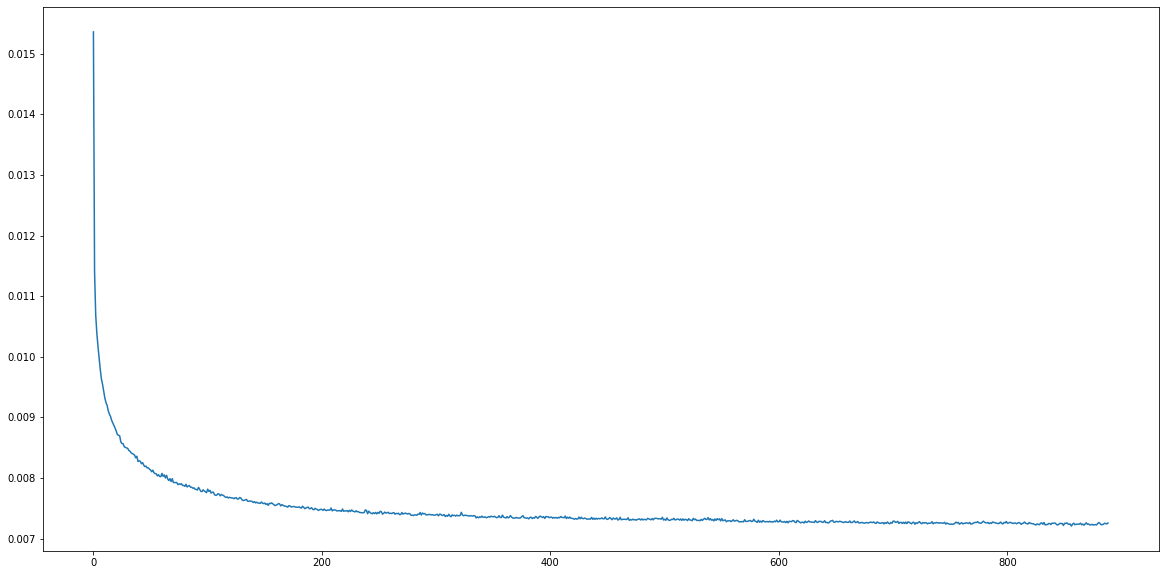

In [155]:
plt.plot(losses['mse_val_loss'])

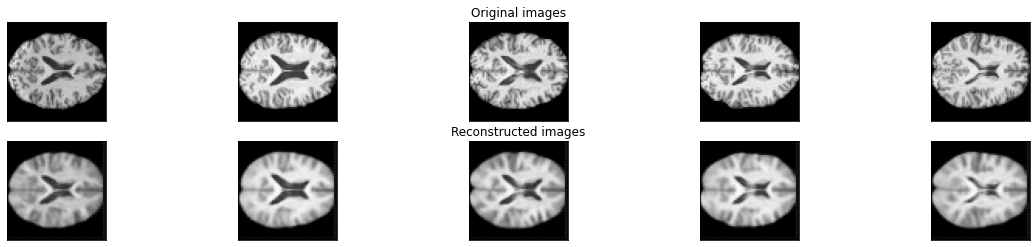

In [109]:
automacaw_model.plot_ae_outputs(val_loader,5)

## Train Flow

In [110]:
es = ES(patience=10, min_delta=2)

for epoch in (pbar := tqdm(range(500))):
    
    nll_train_loss = automacaw_model.train_macaw(train_loader, lr=0.0001)
    nll_val_loss = automacaw_model.test_likelihood(val_loader)
    
    losses['nll_train_loss'].append(nll_train_loss)
    losses['nll_val_loss'].append(nll_val_loss)
    
    pbar.set_description(f"nll_train: {nll_train_loss:.3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}")
    
    if es.early_stop(nll_val_loss):             
        break    

  0%|          | 0/500 [00:00<?, ?it/s]

In [111]:
with open(project_path/'models'/f'UKBB_model_{encoded_dim}.pkl', 'wb') as f:
    pickle.dump({'model':automacaw_model, 'losses':losses}, f)

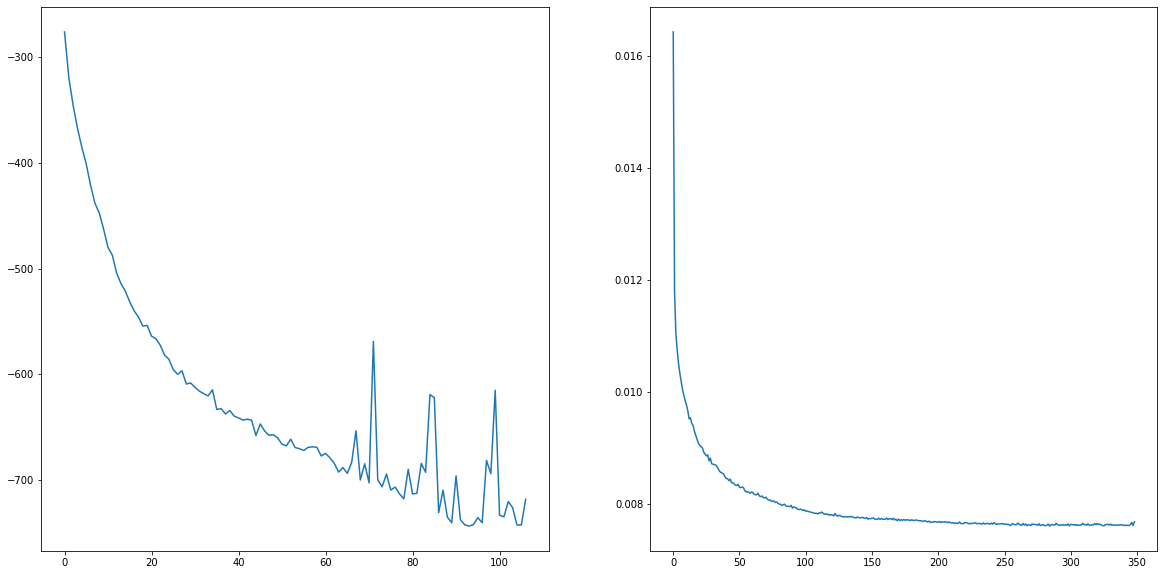

In [112]:
fig, axs = plt.subplots(1,2)
axs[0].plot(losses['nll_val_loss'])
axs[1].plot(losses['mse_val_loss'])

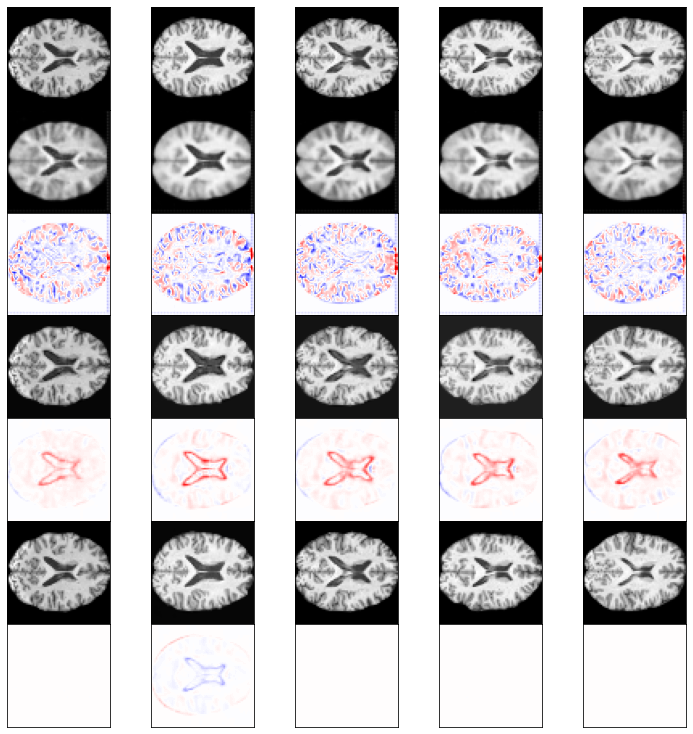

In [113]:
automacaw_model.cf_test(val_loader, 5)

## Fine Tune

In [114]:
with open(project_path/'models'/f'UKBB_model_{encoded_dim}.pkl', 'rb') as f:
    o = pickle.load(f)

automacaw_model = o['model']
losses = o['losses']

In [115]:
alpha = 1
beta = 100

for epoch in (pbar := tqdm(range(250))):
    nll_train_loss, mse_train_loss = automacaw_model.train(train_loader, alpha=alpha, beta=beta,lr=0.00001)
    nll_val_loss, mse_val_loss = automacaw_model.test(val_loader)
    
    losses['nll_train_loss'].append(nll_train_loss)
    losses['mse_train_loss'].append(mse_train_loss)    
    losses['mse_val_loss'].append(mse_val_loss)
    losses['nll_val_loss'].append(nll_val_loss)
    
    # clear_output()
    # fig = cf_test(automacaw_model,val_loader,12)
    
    pbar.set_description(f"mse_train: {mse_train_loss:.6f}, mse_val: {losses['mse_val_loss'][-1]:.6f}, nll_train: {nll_train_loss: .3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}")
    # display(fig)

  0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [116]:
with open(project_path/'models'/f'UKBB_model_joint_{encoded_dim}.pkl', 'wb') as f:
    pickle.dump({'model':automacaw_model, 'losses':losses}, f)

In [139]:
with open(project_path/'models'/f'UKBB_model_joint_{encoded_dim}.pkl', 'rb') as f:
    o = pickle.load(f)

automacaw_model = o['model']
losses = o['losses']

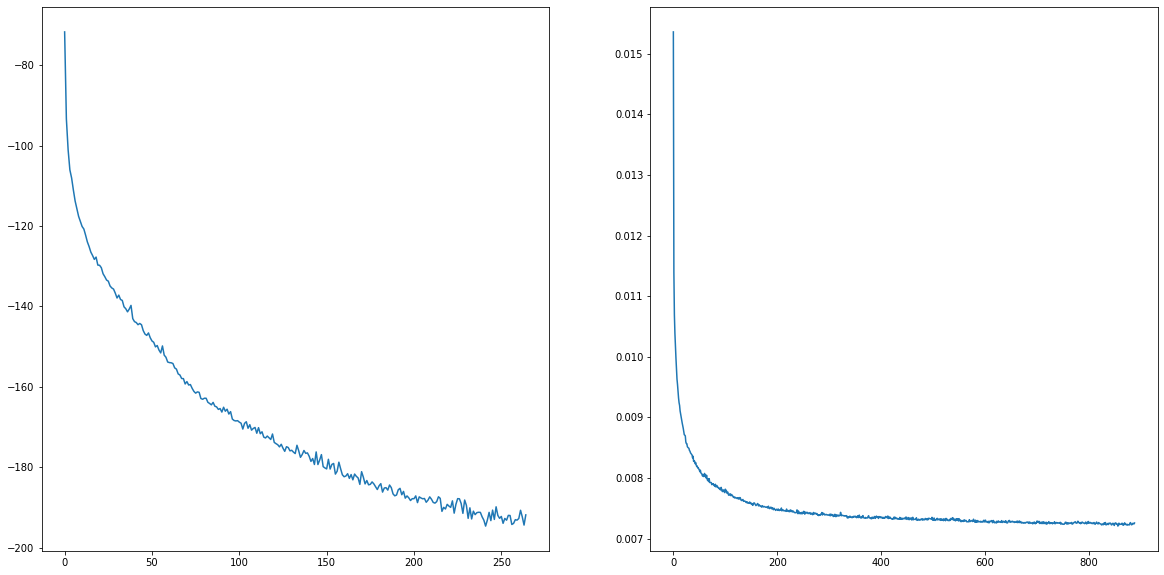

In [156]:
fig, axs = plt.subplots(1,2)
axs[0].plot(losses['nll_val_loss'])
axs[1].plot(losses['mse_val_loss'])

In [141]:
fig.savefig('ukbb_joint_loss_plots.pdf')

In [171]:
encoded_dim = 256

In [176]:
with open(project_path/'models'/f'UKBB_model_joint_{encoded_dim}.pkl', 'rb') as f:
    o = pickle.load(f)

automacaw_model = o['model']
losses = o['losses']

In [177]:
nll_test_loss, mse_test_loss = automacaw_model.test(test_loader)
nll_test_loss, mse_test_loss

(-942.1582, 0.0074781054)

In [178]:
self = automacaw_model

labels = []
predictions = []

with torch.no_grad():
    for batch in test_loader:
        bs = batch[1].shape[0]
        x = automacaw_model._batch_to_x(batch)
        labels += x[:,1].detach().cpu().numpy().tolist()

        x = x.repeat((36, 1))

        for i in range(36):
            x[i * bs:i * bs + bs, 1:2] = i

            
        ll = automacaw_model.macaw.log_likelihood(x).reshape(36, bs)
        predictions += (np.argmax(ll, axis=0).tolist())
        
mae = sum([abs(l - p) for l, p in zip(labels, predictions)]) / len(predictions)
mae

6.139058873179996

In [179]:
predictions_joint = predictions

(array([  46.,  431., 1131., 1354.,  850.,  494.,  130.,   40.,   27.,
         236.]),
 array([ 3. ,  6.2,  9.4, 12.6, 15.8, 19. , 22.2, 25.4, 28.6, 31.8, 35. ]),
 <BarContainer object of 10 artists>)

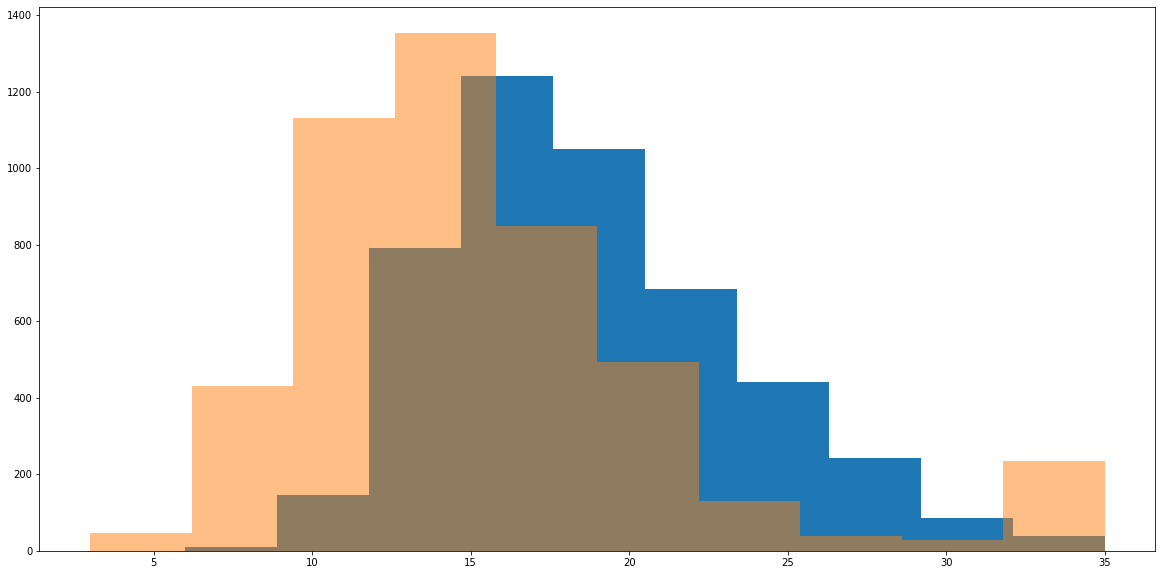

In [184]:
plt.hist(predictions_joint)
plt.hist(predictions_separate, alpha=0.5)

In [181]:
import scipy

scipy.stats.ttest_rel(predictions_joint, predictions_separate)

Ttest_relResult(statistic=46.41153497616046, pvalue=0.0)

In [ ]:
plt.hist

In [149]:
import numpy as np
from sklearn.linear_model import LinearRegression

y = np.array([l-p for p, l in zip(predictions,labels)]).reshape(-1,1)
X = np.array(predictions).reshape(-1,1)


reg = LinearRegression().fit(X, y)
reg.score(X, y)
reg.coef_
reg.intercept_
offset = reg.predict(np.arange(36).reshape(-1,1))

mae = sum([abs(l - p - offset[p,0]) for l, p in zip(labels, predictions)]) / len(predictions)
mae

5.90353214718158

In [204]:
with open(project_path/'models'/'UKBB_model_joint.pkl', 'rb') as f:
    o = pickle.load(f)

automacaw_model = o['model']
losses = o['losses']

In [ ]:
# for e in (pbar := tqdm(range(50))):
#     losses['nll_train_loss'].append(automacaw_model.train_macaw(train_loader))
#     losses['nll_val_loss'].append(automacaw_model.test_likelihood(val_loader))
#     print(f"nll_train: {losses['nll_train_loss'][-1]:.3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}")
    

# import pickle
# with open(macaw_path/'models'/'MIDL'/'macaw_pretrained_ukbb.pkl', 'wb') as f:
#     pickle.dump({'macaw':automacaw_model.macaw, 'encoded_dim':encoded_dim, 'losses':losses}, f)

In [ ]:
import pickle
with open(macaw_path/'models'/'MIDL'/'macaw_pretrained_ukbb.pkl', 'rb') as f:
    macaw_pretrained = pickle.load(f)

automacaw_model.macaw = macaw_pretrained['macaw']
losses = macaw_pretrained['losses']

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses['nll_train_loss'])
plt.plot(losses['nll_val_loss'])

In [ ]:
automacaw_model.cf_test(val_loader, nsamples=5)

In [ ]:
automacaw_model2 = automacaw(encoded_dim)
losses2 = {'mse_train_loss':[],'mse_val_loss':[],'nll_train_loss':[],'nll_val_loss':[]}

In [ ]:
# for epoch in (pbar := tqdm(range(100))):
#     losses2['mse_train_loss'].append(automacaw_model2.train_residual_encoder_decoder(automacaw_model, train_loader, lr=0.001))
#     losses2['mse_val_loss'].append(automacaw_model2.test_residual_MSE(automacaw_model, val_loader))
#     print(f'Epoch: {epoch}, Val_loss: {losses2["mse_val_loss"][-1]}')

#     clear_output()
#     display(automacaw_model2.plot_residual_ae_outputs(automacaw_model, val_loader))

# import pickle
# with open(macaw_path/'models'/'MIDL'/'ae_pretrained_ukbb2.pkl', 'wb') as f:
#     pickle.dump({'encoder':automacaw_model2.encoder, 'decoder':automacaw_model2.decoder, 'encoded_dim':encoded_dim, 'losses':losses2}, f)

In [ ]:
plt.plot(losses2['mse_train_loss'])
plt.plot(losses2['mse_val_loss'])

In [ ]:
import pickle
with open(macaw_path/'models'/'MIDL'/'ae_pretrained_ukbb2.pkl', 'rb') as f:
    ae_pretrained = pickle.load(f)

automacaw_model2.encoder = ae_pretrained['encoder']
automacaw_model2.decoder = ae_pretrained['decoder']
automacaw_model2.encoded_dim = ae_pretrained['encoded_dim']
losses2 =  ae_pretrained['losses']

In [ ]:
display(automacaw_model2.plot_residual_ae_outputs(automacaw_model, val_loader))


In [ ]:
# for e in (pbar := tqdm(range(50))):
#     losses2['nll_train_loss'].append(automacaw_model2.train_macaw_residual(automacaw_model,train_loader))
#     losses2['nll_val_loss'].append(automacaw_model2.test_likelihood_residual(automacaw_model, val_loader))
#     print(f"nll_train: {losses2['nll_train_loss'][-1]:.3f}, nll_val: {losses2['nll_val_loss'][-1]:.3f}")
  
# import pickle
# with open(macaw_path/'models'/'MIDL'/'macaw_pretrained_ukbb2.pkl', 'wb') as f:
#     pickle.dump({'macaw':automacaw_model2.macaw, 'encoded_dim':encoded_dim, 'losses':losses2}, f)

In [ ]:
import pickle
with open(macaw_path/'models'/'MIDL'/'macaw_pretrained_ukbb2.pkl', 'rb') as f:
    macaw_pretrained2 = pickle.load(f)

automacaw_model2.macaw = macaw_pretrained2['macaw']
losses2 = macaw_pretrained2['losses']

In [ ]:
plt.plot(losses2['nll_train_loss'])

In [ ]:
automacaw_model2.cf_test_residual(automacaw_model,val_loader, nsamples=5 )

In [ ]:
fig, obs, cf_images_l, cf_images_h, cf_images_h_norm = automacaw_model2.cf_test_all(automacaw_model,val_loader, cf_vals={1:75-automacaw_model.min_age}, nsamples=5, figsize=(14,5))
fig

In [ ]:
fig.savefig('/data/Papers/MIDL2024/do75.pdf',bbox_inches='tight')

In [ ]:
 fig, obs, cf_images_l, cf_images_h, cf_images_h_norm = automacaw_model2.cf_test_all(automacaw_model,val_loader, cf_vals={1:50-automacaw_model.min_age}, nsamples=5, figsize=(14,5))
fig

In [ ]:
fig.savefig('/data/Papers/MIDL2024/do50.pdf',bbox_inches='tight')

In [ ]:
fig, obs, cf_images_l, cf_images_h, cf_images_h_norm = automacaw_model2.cf_test_all(automacaw_model,val_loader, cf_vals={0:1}, nsamples=5,figsize=(14,5))
fig

In [ ]:
fig.savefig('/data/Papers/MIDL2024/doMale.pdf',bbox_inches='tight')

In [ ]:
fig, obs, cf_images_l, cf_images_h, cf_images_h_norm = automacaw_model2.cf_test_all(automacaw_model,val_loader, cf_vals={0:0}, nsamples=5,figsize=(14,5))
fig

In [ ]:
fig.savefig('/data/Papers/MIDL2024/doFemale.pdf',bbox_inches='tight')

In [ ]:
np.min(obs[0]+cf_images_l[0]+cf_images_h_norm[0])

In [ ]:
np.max(orig_res_batch.cpu().numpy()[0])
np.quantile(orig_res_batch.cpu().numpy()[0],0.97)

In [ ]:
np.max(cf_images_h[0])

In [ ]:
automacaw_model = automacaw(encoded_dim)
losses = {'mse_train_loss':[],'mse_val_loss':[],'nll_train_loss':[],'nll_val_loss':[]}

for e in (pbar := tqdm(range(10))):
    losses['nll_train_loss'].append(automacaw_model.train_encoder_macaw(train_loader))
    losses['nll_val_loss'].append(automacaw_model.test_likelihood(val_loader))
    losses['mse_val_loss'].append(automacaw_model.test_MSE(val_loader))
    pbar.set_description(f"nll_train: {losses['nll_train_loss'][-1]:.3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}, mse_val: {losses['mse_val_loss'][-1]:.3f}")

for epoch in (pbar := tqdm(range(60))):
    losses['mse_train_loss'].append(automacaw_model.train_encoder_decoder(train_loader))
    losses['mse_val_loss'].append(automacaw_model.test_MSE(val_loader))
    losses['nll_val_loss'].append(automacaw_model.test_likelihood(val_loader))
    pbar.set_description(f"mse_train: {losses['mse_train_loss'][-1]:.3f}, mse_val: {losses['mse_val_loss'][-1]:.3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}")

for epoch in (pbar := tqdm(range(50))):
    losses['nll_train_loss'].append(automacaw_model.train_macaw(train_loader))
    losses['mse_val_loss'].append(automacaw_model.test_MSE(val_loader))
    losses['nll_val_loss'].append(automacaw_model.test_likelihood(val_loader))
    pbar.set_description(f"nll_train: {losses['nll_train_loss'][-1]:.3f}, mse_val: {losses['mse_val_loss'][-1]:.3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}")

joined_losses[fold] = losses    
    
# display(automacaw_model.plot_ae_outputs(val_loader))

# import pickle
# with open(macaw_path/'models'/'MIDL'/'ae_pretrained.pkl', 'wb') as f:
#     pickle.dump({'encoder':automacaw.encoder, 'decoder':automacaw.decoder, 'encoded_dim':encoded_dim, 'losses':losses}, f)

In [ ]:
sex = np.concatenate([d[0].numpy() for d in train_loader],axis=0)
age = np.concatenate([d[1].numpy() for d in train_loader],axis=0)
bmi = np.concatenate([d[2].numpy() for d in train_loader],axis=0)

In [ ]:
from sklearn.preprocessing import StandardScaler

age = np.round(age)
min_age = np.min(age)
age-=min_age

In [ ]:
show(next(iter(test_loader)))

In [ ]:
test_imgs = np.concatenate([d[3].numpy() for d in test_loader],axis=0)
test_imgs = test_imgs.reshape(test_imgs.shape[0],-1)
test_imgs_dim = test_imgs.shape[1]

In [ ]:
import utils.visualize as vis

plt.rcParams["figure.figsize"] = 20,5

diff = sample_imgs - X_recon
rr = X_recon + diff
fig = vis.img_grid([np.rot90(d.reshape(crop_size,crop_size)) for d in sample_imgs], clim=(0,1), cols=5)
fig = vis.img_grid([np.rot90(d.reshape(crop_size,crop_size)) for d in X_recon], clim=(0,1), cols=5)
fig = vis.img_grid([np.rot90(d.reshape(crop_size,crop_size)) for d in diff], clim=(-1,1), cols=5, cmap='seismic')
fig = vis.img_grid([np.rot90(d.reshape(crop_size,crop_size)) for d in rr], clim=(0,1), cols=5)

In [ ]:
sex = np.concatenate([d[0].numpy() for d in test_loader],axis=0)
age = np.concatenate([d[1].numpy() for d in test_loader],axis=0)
bmi = np.concatenate([d[2].numpy() for d in test_loader],axis=0)

In [ ]:
from sklearn.preprocessing import StandardScaler

age = np.round(age)
age-=min_age

encoded_data = kpca.transform(test_imgs)

In [ ]:
with open(test_path, 'wb') as f:
    pickle.dump({'imgs':test_imgs, 'sex':sex,'age':age, 'bmi':bmi, 'kpca':kpca,'encoded_data':encoded_data, 'min_age':min_age}, f)